# Tutorial 2: data preparation for deeptb-sk model

## Introduction
**DeePTB** is a method that uses deep learning to accelerate first-principles electronic structure simulations.

### Version Features
- **v1**: Constructed tight-binding (TB) models with first-principles accuracy (DeePTB-SK)
- **v2.0-2.1**: Added E3 equivariant networks to represent single-electron operators (Hamiltonian, density matrix, and overlap matrix) (DeePTB-E3)
- **v2.2**: Incorporated built-in SK empirical parameters covering commonly used elements across the periodic table

Through these capabilities, DeePTB provides multiple approaches to accelerate electronic structure simulations of materials.

### Learning Objectives

In this tutorial, you will:
1. Learn how to prepare data from DFT output to DeePTB-SK data for both abacus and vasp.
2. Become familiar with the initial training scheme for DeePTB-SK

## 1. Prepare Data for DeePTB-SK Model
This section will show how to prepare data for DeePTB-SK model. The training label of DeePTB-SK model is the energy eigenvalue. This tutorial will show the usage of DFTIO with two DFT software, abacus and VASP.

### Pre-requisites
1. Install DFTIO, see https://github.com/deepmodeling/dftio.git
2. Run DFT Calculation:
   
   For a given structure, perform static calculations using either ABACUS or VASP. Self-consistent or non-self-consistent calculations are both acceptable. This tutorial will use ABACUS and VASP as examples to prepare data. The following sections will describe the usage of DFTIO for both software.
   
You can run `dftio -h` and `dftio <command> -h` to view the help documentation.

In [124]:
!dftio -h

usage: dftio [-h] [-v] {parse,band} ...

dftio is to assist machine learning communities to transcript DFT output into
a format that is easy to read or used by machine learning models.

options:
  -h, --help     show this help message and exit
  -v, --version  show the dftio's version number and exit

Valid subcommands:
  {parse,band}
    parse        parse dataset from DFT output
    band         plot band for eigenvalues data


In [ ]:
!dftio parse -h

###  1.1 ABACUS Case:

The following folder contains the result files from ABACUS calculations. We will demonstrate how to convert the ABACUS calculation data into the training data format for the DeePTB-SK model using a single command.

In [125]:
import os
workdir='/home/mayuan/code/sctheory/DeePTB/examples/GaAs_io_sk/data'
os.chdir(f"{workdir}")
!tree -L 1 ./

./
├── ABACUS
├── VASP
├── abc_ase
└── vasp_ase

4 directories, 0 files


The command to process the data is as follows:

In [126]:
! dftio parse -m abacus -r ./ -p ABACUS -f ase -o abc_ase -eig

Parsing the DFT files: 100%|█████████████████████| 1/1 [00:00<00:00, 228.34it/s]


The command above, the meaning of each parameter is as follows:
- `-m`: Specify the software, can be abacus, vasp, etc., default is abacus
- `-r`: root_dir, the root directory of the calculation results
- `-p`: prefix, the prefix of the calculation results, will search all file names: The retrieval rule is: `glob.glob(root + '/*' + prefix + '*')`
- `-f`: format output data format: dat ase lmdb; For eigenvalue training data, dat ase is a common format. lmdb is mainly for training quantum operator matrices.
- `-o`: out_dir output folder, root_dir/out_dir
- `-eig`: Whether to output eigenvalues, add -eig to set it to True
  
The following command provides a preview of the corresponding eigenvalue band structure, which is convenient for analysis:

Figure(640x480)


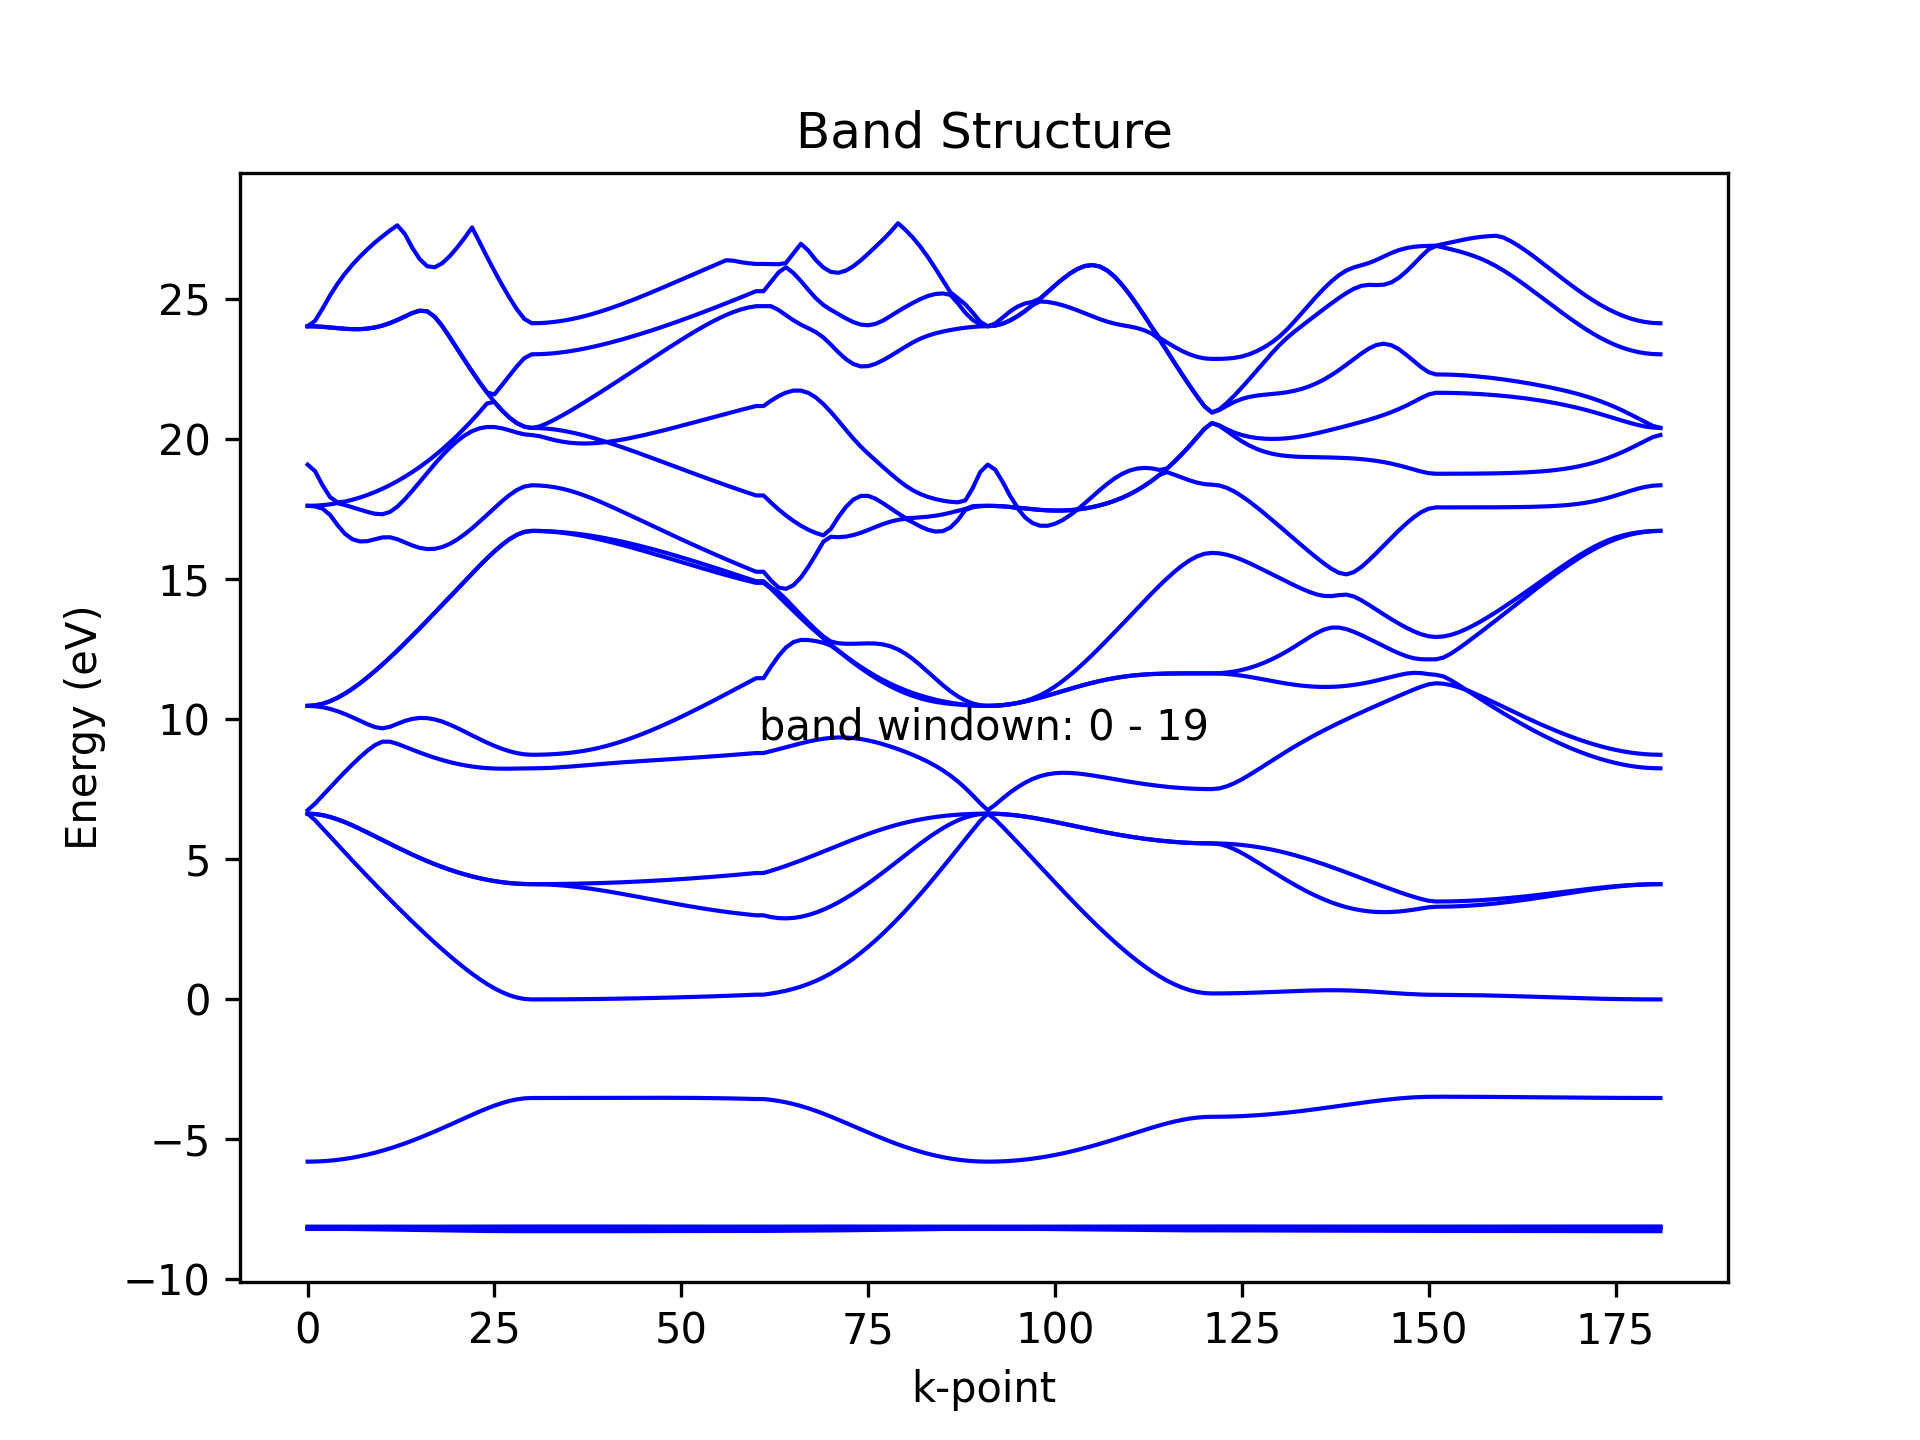

In [127]:
!dftio band -r ./abc_ase/AsGa.0 -f ase 

# display the band plot:
from IPython.display import Image, display
import os
image_path = f'{workdir}/abc_ase/AsGa.0/band_structure.png'
display(Image(filename=image_path))

The plotting command:
```python
dftio band -r ./abc_ase/AsGa.0 -f ase 
```
The meaning of the parameters is as follows:
- `-r` : root_dir, the root directory of the calculation results. Batch plotting is not supported here, so we directly specify the folder containing the parsed data from the previous step without using the prefix and search folder mode.
- `-f` : format, corresponding to the output format during parsing, ase or dat

### Band structure analysis

For the above band structure, we can see that some bands belong to core orbitals. We do not need these bands for training the TB model. We can remove these bands by adding an extra parameter to the above command.

We first check how many bands we want to remove. We can visualize the band structure to see this:

Figure(640x480)


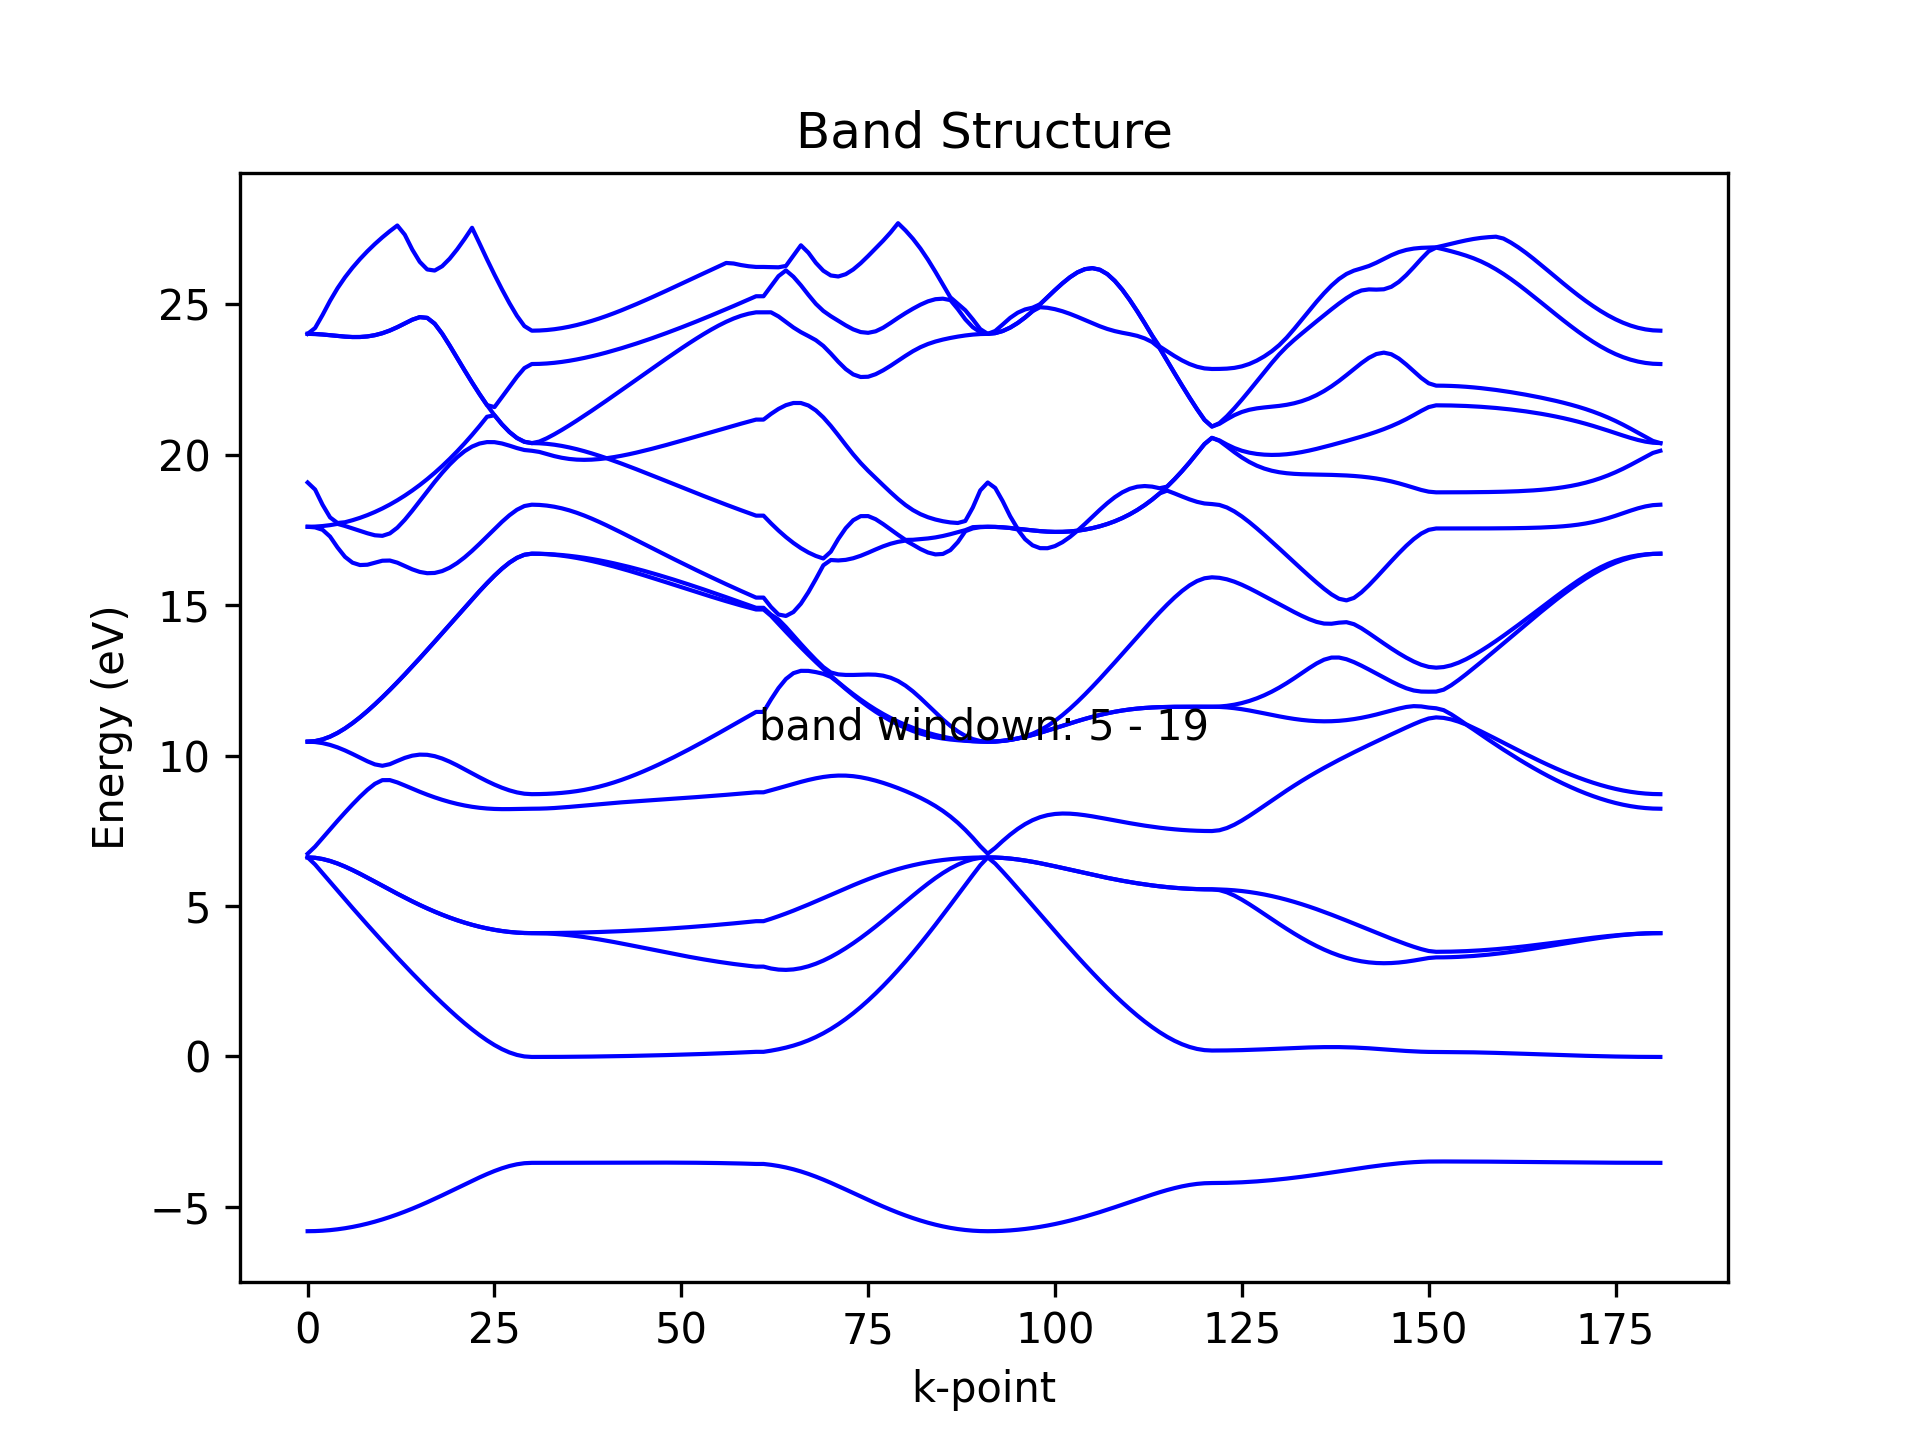

In [128]:
!dftio band -r ./abc_ase/AsGa.0 -f ase -min 5

# display the band plot:
from IPython.display import Image, display
import os
image_path = f'{workdir}/abc_ase/AsGa.0/band_structure.png'
display(Image(filename=image_path))

Note that the above plotting command has an extra parameter:
- `-min` specifies the starting band for plotting. 

For example, `-min 5` means starting from the 5th band, as the counting starts from 0. This indicates that the first 5 bands are completely discarded.

Users can change the value of `-min` to check the band structure. After determining the appropriate value for `-min`, we can rerun the `dftio parse` command with this parameter. 

Additionally, users should ensure that the chosen `-min` value does not exceed the total number of bands available in the dataset.

In [129]:
!dftio parse -m abacus -r ./ -p ABACUS -f ase -o abc_ase -eig -min 5

Parsing the DFT files: 100%|█████████████████████| 1/1 [00:00<00:00, 504.43it/s]


The above command will remove the first 5 bands from the band structure plot. 

Figure(640x480)


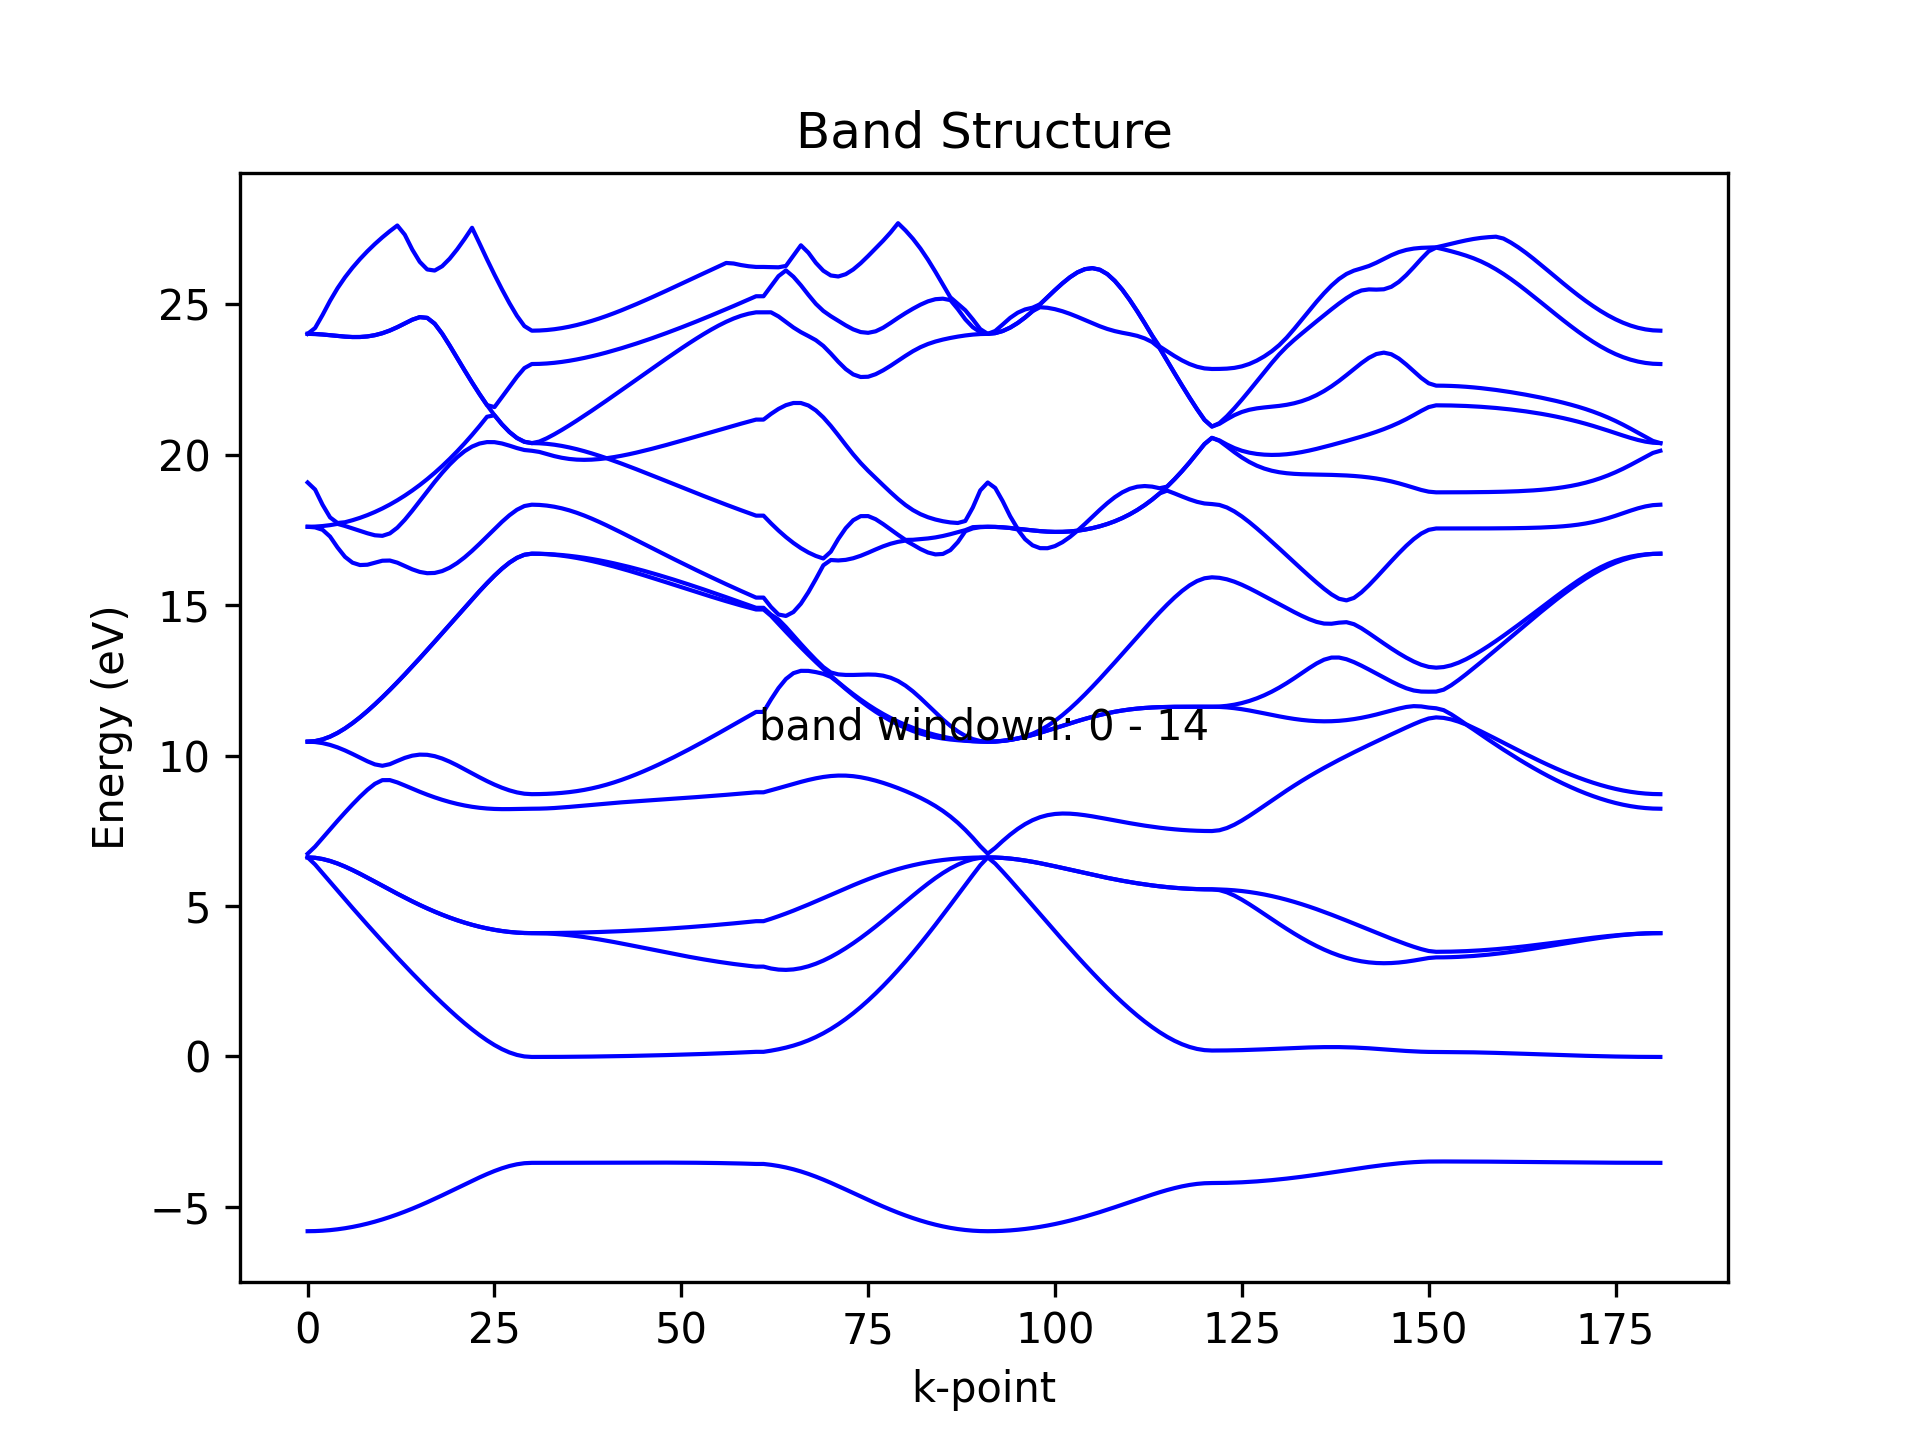

In [130]:
!dftio band -r ./abc_ase/AsGa.0 -f ase # -min 0

# display the band plot:
from IPython.display import Image, display
import os
image_path = f'{workdir}/abc_ase/AsGa.0/band_structure.png'
display(Image(filename=image_path))

### Finally, the training data set format for DeePTB-SK model is obtained. 

In [131]:
!tree -L 2 ./abc_ase

./abc_ase
└── AsGa.0
    ├── band_structure.png
    ├── eigenvalues.npy
    ├── kpoints.npy
    └── xdat.traj

1 directory, 4 files


###  1.2. VASP Case:

The following folder contains the result files from VASP calculations.

In [132]:
workdir='/home/mayuan/code/sctheory/DeePTB/examples/GaAs_io_sk/data/'
os.chdir(f"{workdir}")
! tree ./VASP -L 1

./VASP
├── EIGENVAL
├── KPOINTS
├── OUTCAR
└── POSCAR

0 directories, 4 files


using the same command as in the ABACUS case, but with the `-m` parameter set to `vasp`:

In [133]:
! dftio parse -m vasp -r ./ -p VASP -f ase -o vasp_ase -eig

DFTIO WARNING VASP parser only supports the static (SCF or NSCF) calculations. MD and RELAX is not supported yet.
Parsing the DFT files: 100%|██████████████████████| 1/1 [00:00<00:00, 54.77it/s]


Observe that the above command is the same as the abacus case, except for the `-m` parameter, which is set to `vasp`.

For visualizing the band structure of data already output in ASE format, the process is similar to that of the ABACUS case. 

Figure(640x480)


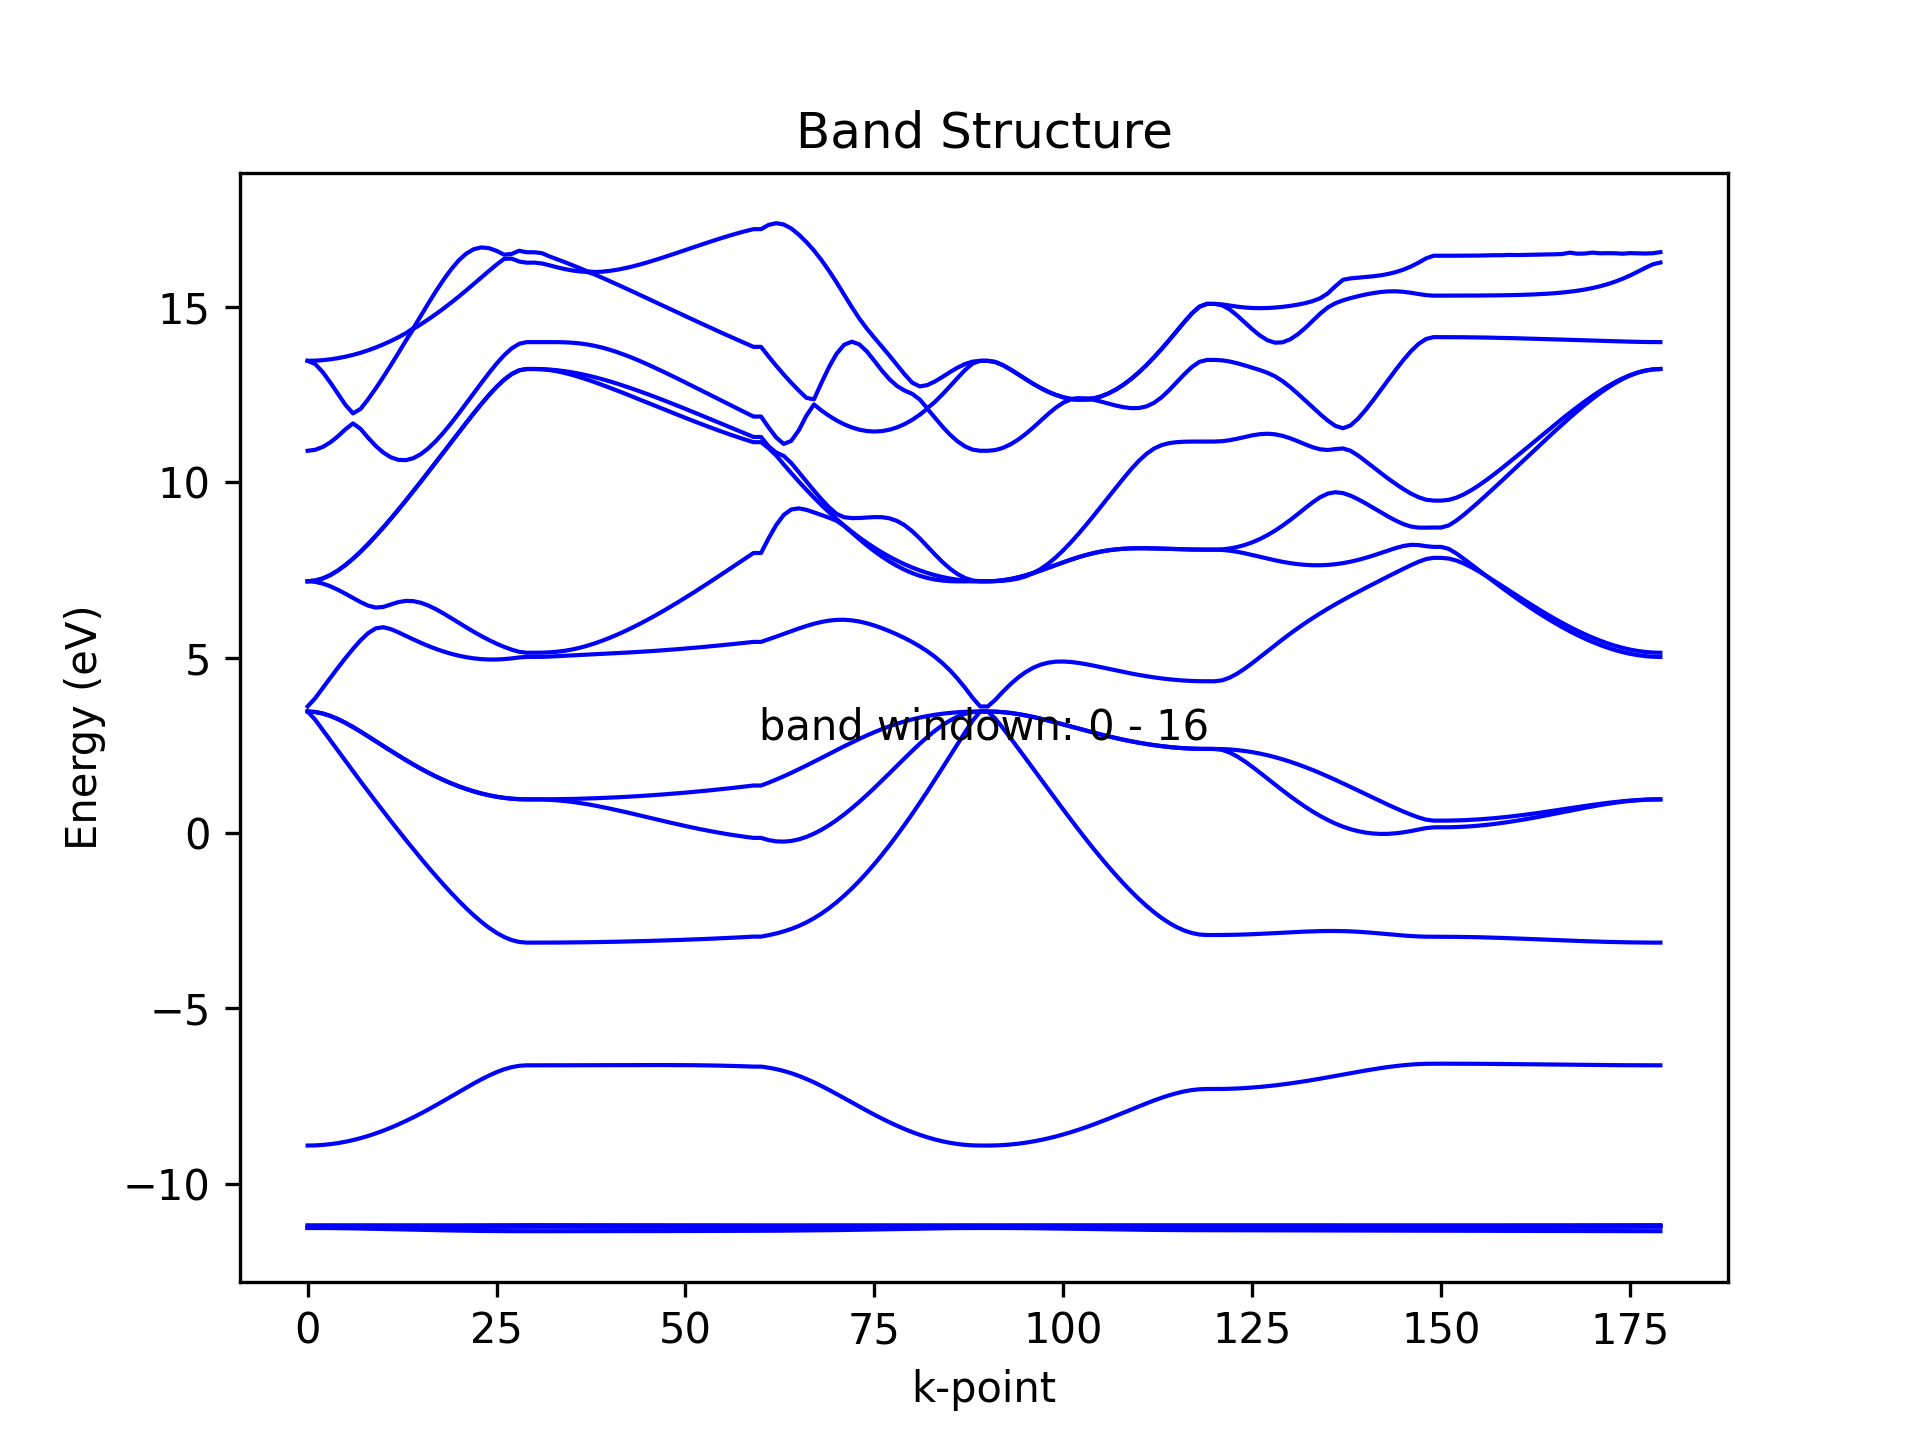

In [134]:
!dftio band -r ./vasp_ase/AsGa.0 -f ase 

# display the band plot:
from IPython.display import Image, display
import os
image_path = f'{workdir}/vasp_ase/AsGa.0/band_structure.png'
display(Image(filename=image_path))

Again, there are core orbitals in the band structure. We can use the same method as in the ABACUS case to remove these bands.

Again, by visualization, we can get the information about how many bands need to be removed:

Figure(640x480)


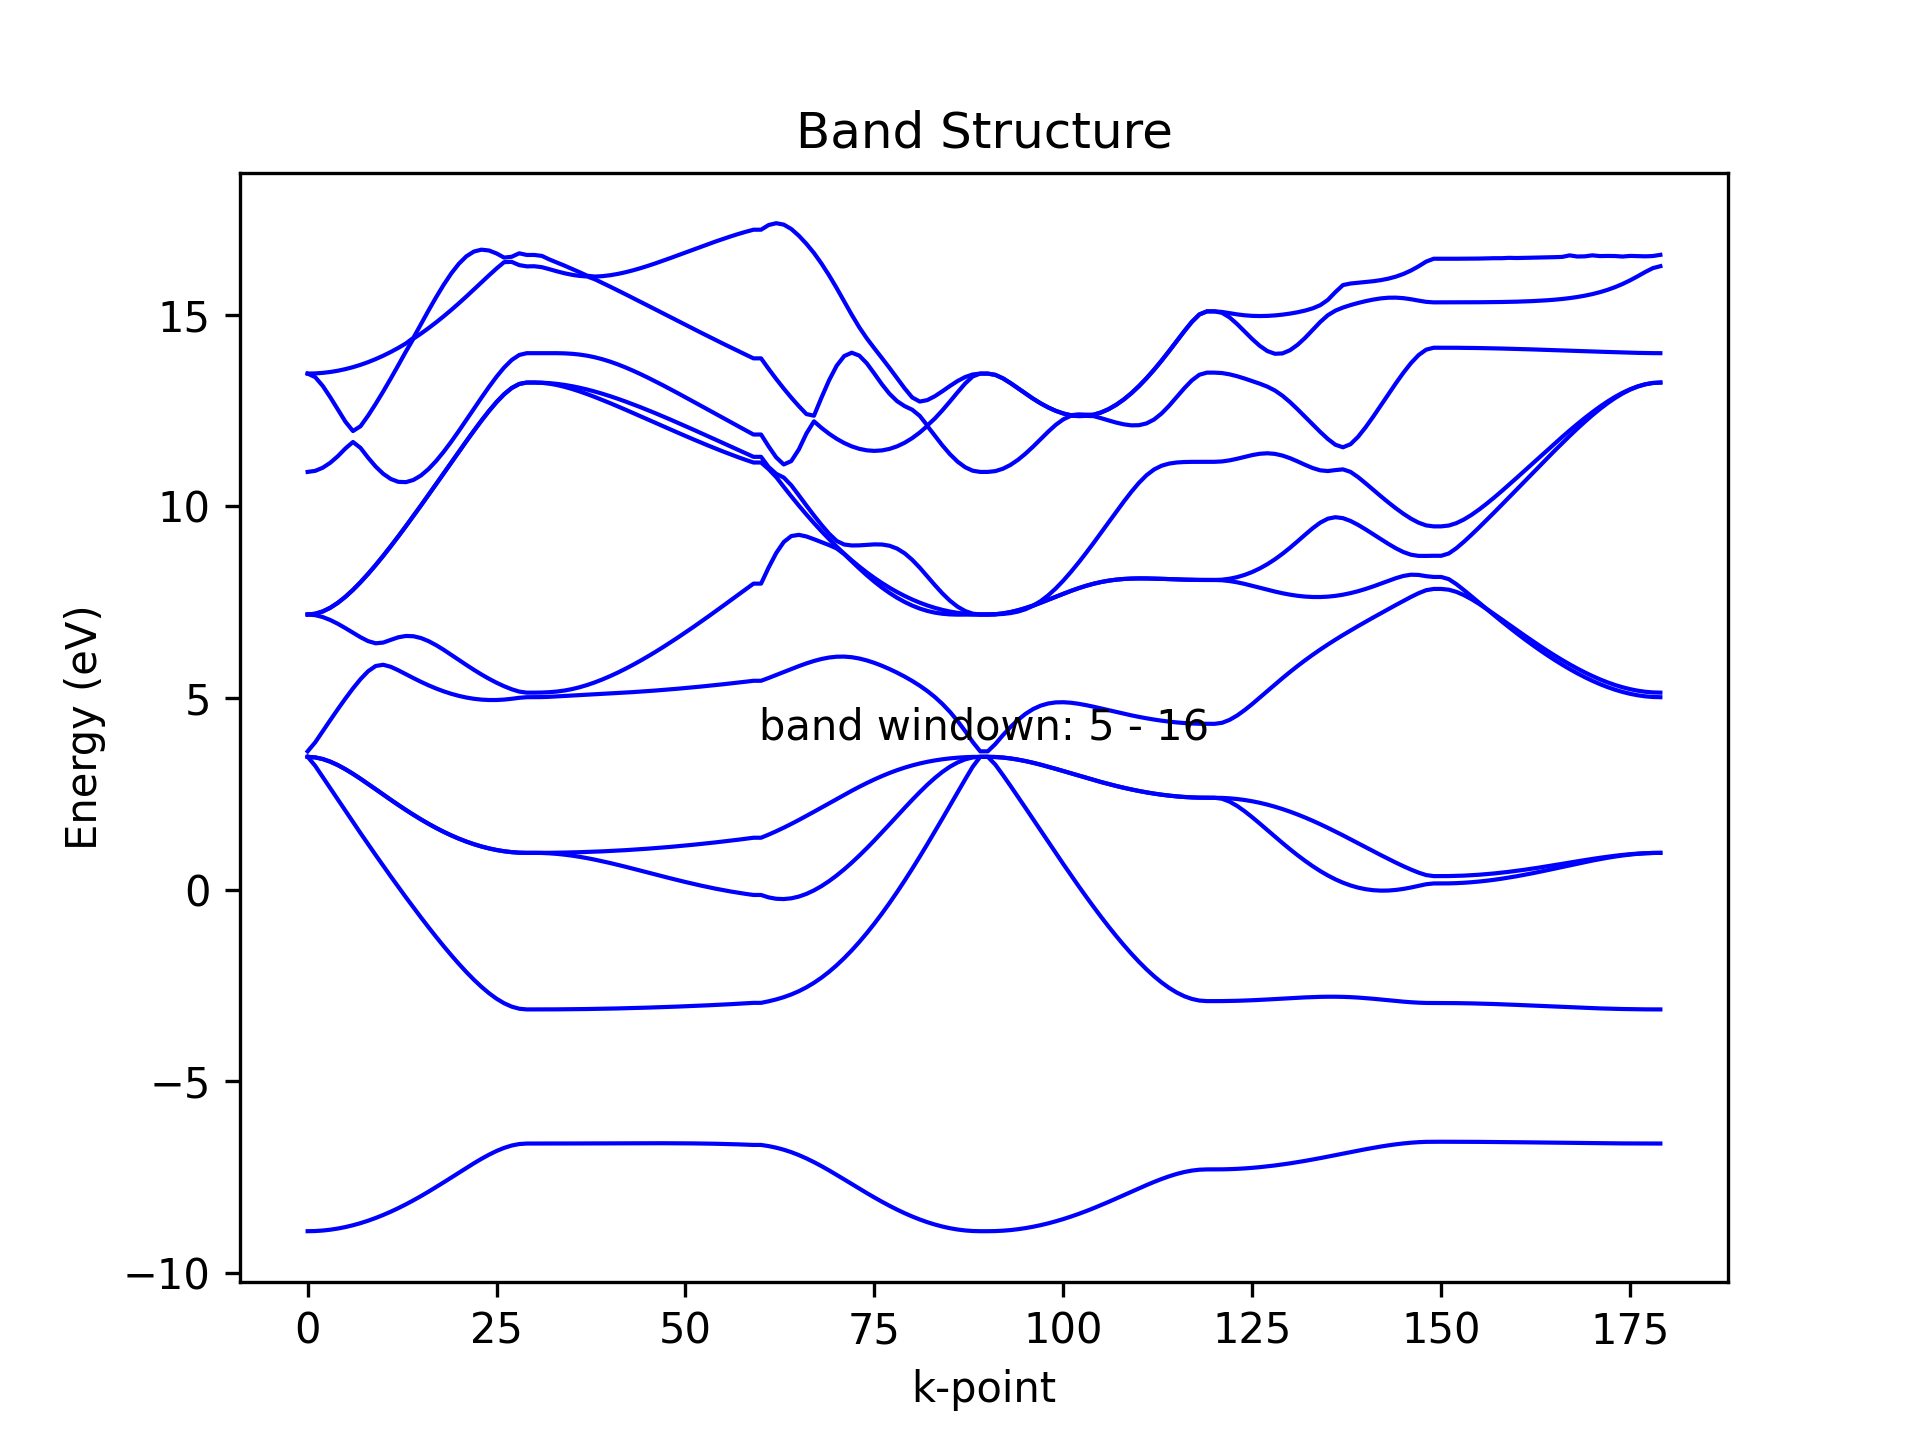

In [135]:
!dftio band -r ./vasp_ase/AsGa.0 -f ase  -min 5

# display the band plot:
from IPython.display import Image, display
import os
image_path = f'{workdir}/vasp_ase/AsGa.0/band_structure.png'
display(Image(filename=image_path))

Re-run the data processing command to discard the lower energy bands. The command is as follows:

In [136]:
! dftio parse -m vasp -r ./ -p VASP -f ase -o vasp_ase -eig -min 5

DFTIO WARNING VASP parser only supports the static (SCF or NSCF) calculations. MD and RELAX is not supported yet.
Parsing the DFT files: 100%|█████████████████████| 1/1 [00:00<00:00, 179.06it/s]


To confirm the band structure, we can visualize it again. The command is as follows:

Figure(640x480)


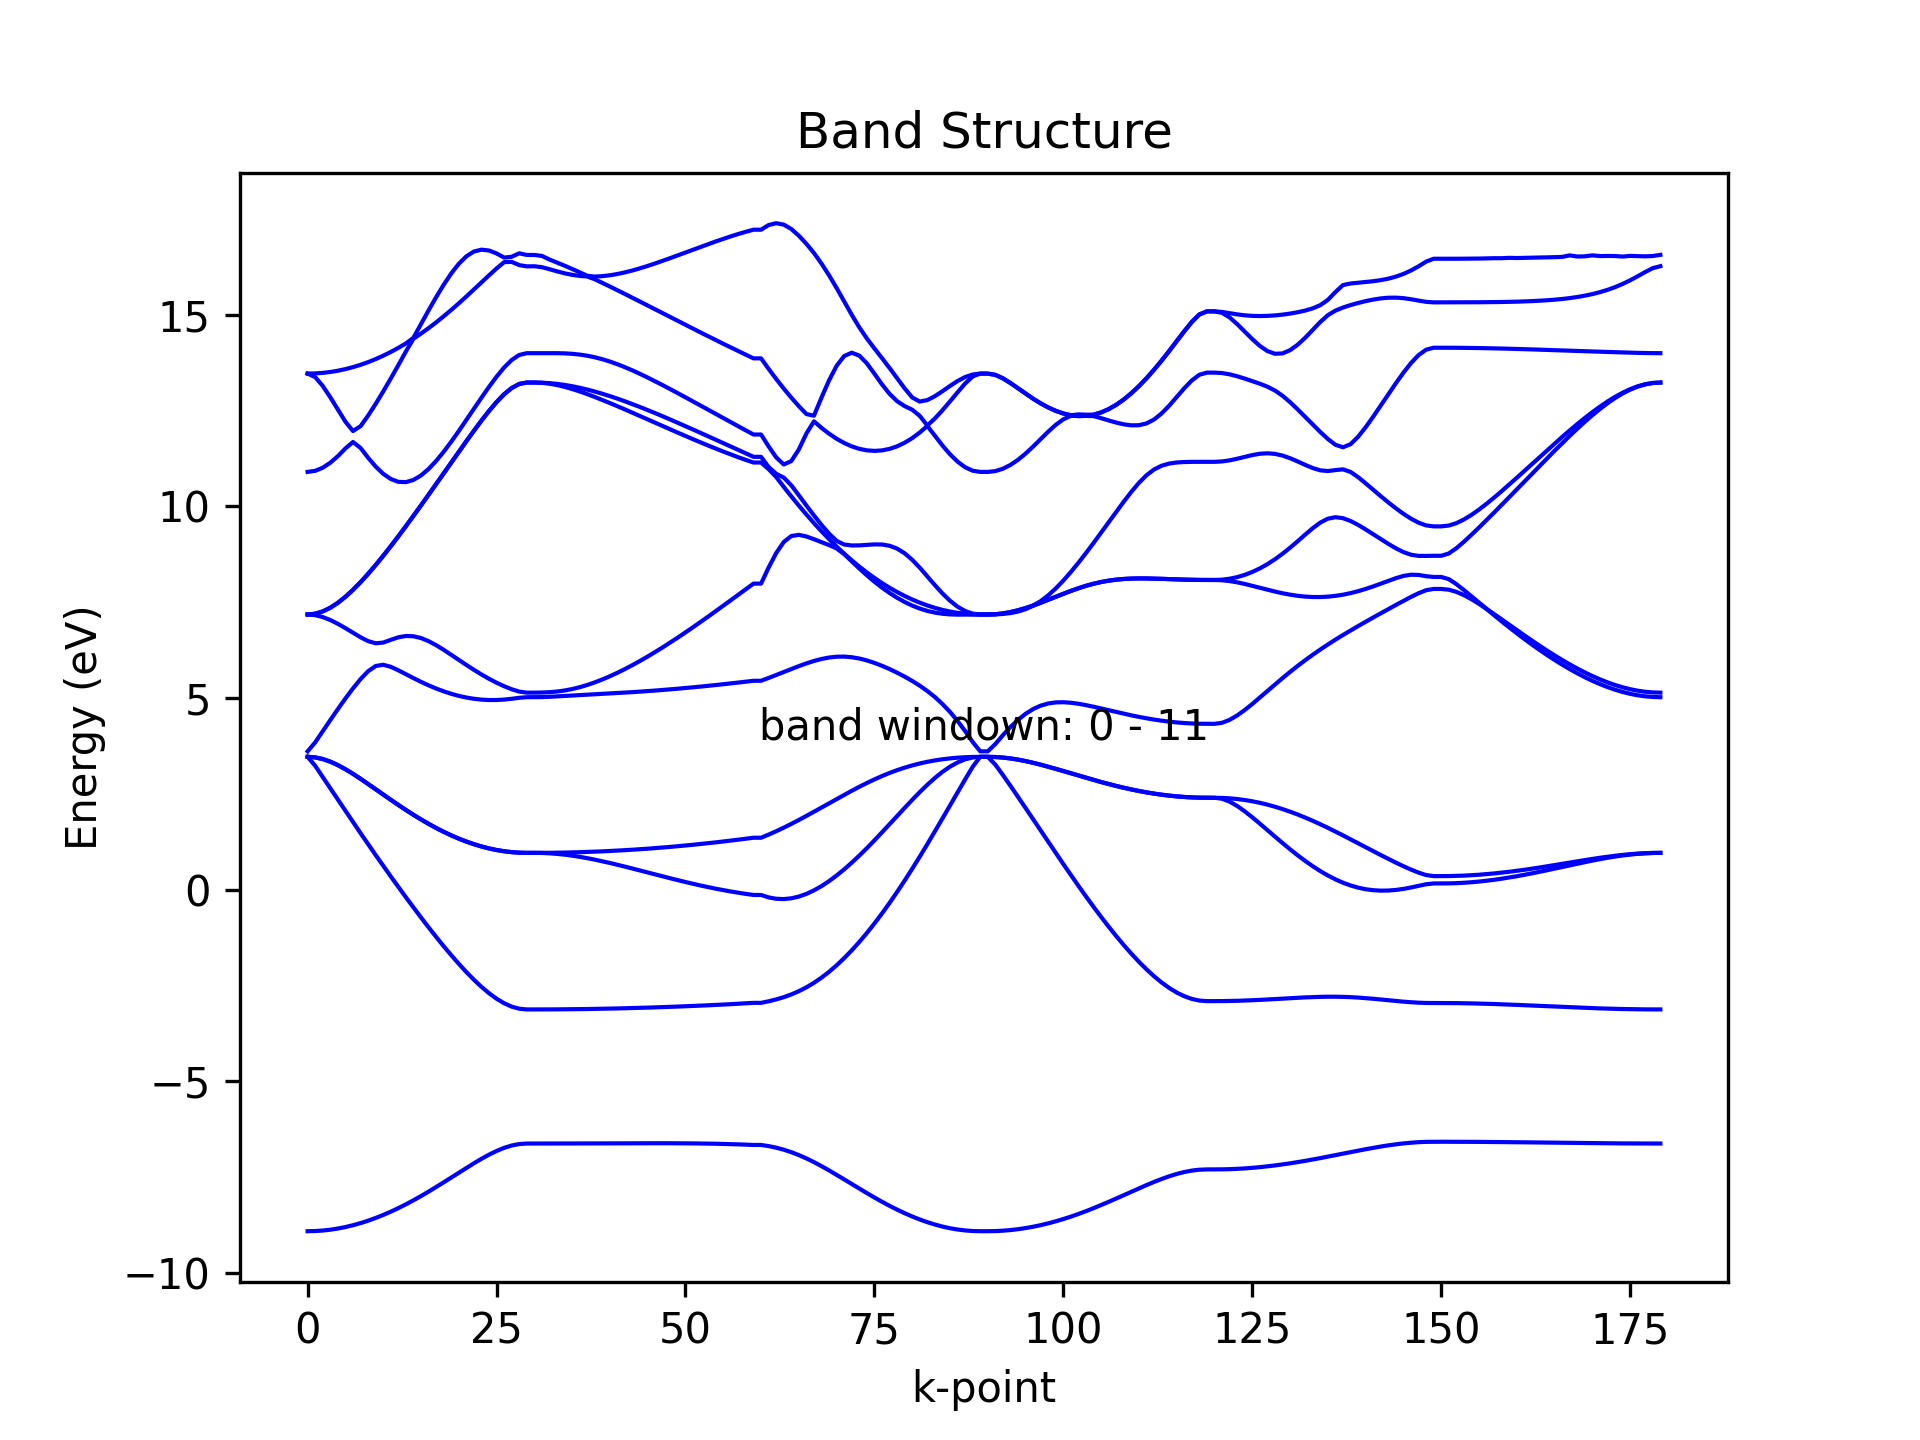

In [137]:
!dftio band -r ./vasp_ase/AsGa.0 -f ase # -min 5

# display the band plot:
from IPython.display import Image, display
import os
image_path = f'{workdir}/vasp_ase/AsGa.0/band_structure.png'
display(Image(filename=image_path))

### Finally, the training data set format for DeePTB-SK model is obtained. 

**Note:**

After the above operations, the obtained data only contains one frame structure. If you have multiple frame structures, you can perform the following two operations:

1. Place different structures in different folders, using the same prefix and different suffixes for naming. Different folders should be placed in the same directory. The data structure is as follows:
    ```bash
      .root_dir
      └── prefix.suffix1
          ├── info.json
          ├── eigenvalues.npy
          ├── kpoints.npy
          └── xdat.traj
      └── prefix.suffix2
          ├── info.json
          ├── eigenvalues.npy
          ├── kpoints.npy
          └── xdat.traj
      └── ...
    ```

    **Note**: You may notice that I added an `info.json` file! This file contains some parameter settings for the training set, which are required when training DeePTB-SK. Please refer to the DeePTB-SK tutorial for details.

2. In another case, if the data for different frames of structures is the same except for the atomic coordinates (e.g., different structures in the same MD trajectory), you can merge them into one file. The `xdat.traj` file is used to save different frames of structures, and the shape of `eigenvalues.npy` is [nframe,nk,nb]. The shape of `kpoints` can be [nframe,nk,nb] or [nk,nb], where the latter indicates that this structure uses the same kpoints.


## 2. **Training DeePTB-SK Model using vasp data**

In the previous step, we have prepared the data, and now we can start training the model.

In [138]:
import os
workdir='/home/mayuan/code/sctheory/DeePTB/examples/GaAs_io_sk/'
os.chdir(f"{workdir}")
! tree -L 1 ./data/vasp_ase

./data/vasp_ase
├── AsGa.0
├── processed_dataset_208691086618072699a9e85d72017e87a7ed405d
├── processed_dataset_3b2f2e8b933f33b91e3858a9782cd9eba23d3f58
├── processed_dataset_3bc722808f98346176dd4f6028efadf78b6d366a
├── processed_dataset_81a9de8a68b1e19cd2b5280f3c6b95d27bb756a1
└── processed_dataset_f09c2f6c4a7ad9cc49195d9d560c624515a5fa8f

6 directories, 0 files



First, we need to create an `info.json` file in the data folder with the following content:
```json
{
    "nframes": 1,
    "natoms": 2,
    "pos_type": "ase",
    "pbc": true,
    "bandinfo": {
        "band_min": 0,
        "band_max": 8,
        "emin": null, # 这里如果不赋值，就无法拟合出来正确的TB能带 
        "emax": null  #
    }
}
```
`nframes` indicates the number of trajectory snapshots, `natoms` indicates the number of atoms in each snapshot, `pos_type` indicates the coordinate type, and `pbc` indicates whether periodic boundary conditions are applied. The `bandinfo` section contains information about the band window, which can be set according to the user's needs. The band window information can be sorted by band index or divided by energy range. Note that the value of emin is relative to min(eig[band_min]). Taking min(eig[band_min]) as the 0 energy.

In [149]:
eigs = np.load("/home/mayuan/code/sctheory/DeePTB/examples/GaAs_io_sk/data/vasp_ase/AsGa.0/eigenvalues.npy")
print(eigs[0][0])
print(len(eigs))
print(f"最小值 (Min): {eigs.min()}")
print(f"最大值 (Max): {eigs.max()}")

[-8.907119  3.466853  3.466855  3.466855  3.610277  7.179522  7.179526
  7.179526 10.899148 13.463815 13.46382 ]
1
最小值 (Min): -8.907118797302246
最大值 (Max): 17.38686752319336


In [154]:
import json 

infodict = {
    "nframes": 1,
    "natoms": 2,
    "pos_type": "ase",
    "pbc": True,
    "bandinfo": {
        "band_min": 0,
        "band_max": 8,
        "emin": -10,
        "emax": None
        }
    }

with open(f'{workdir}/data/vasp_ase/AsGa.0/info.json', 'w') as f:
    json.dump(infodict, f, indent=4)

### 2.1 Extract initial empirical SK parameters

Refer to tutorial 1, we extract the initial SK parameters of GaAs from the built-in baseline model.

In [ ]:
os.chdir(f"{workdir}/train")
!dptb esk gaas.json -m poly4 

TBPLaS is not installed. Thus the TBPLaS is not available, Please install it first.
╭──────────────────────── Deep Learning Tight-Binding ─────────────────────────╮
│                                                                              │
│     ██████████                     ███████████  ███████████ ███████████      │
│    ░░███░░░░███                   ░░███░░░░░███░█░░░███░░░█░░███░░░░░███     │
│     ░███   ░░███  ██████   ██████  ░███    ░███░   ░███  ░  ░███    ░███     │
│     ░███    ░███ ███░░███ ███░░███ ░██████████     ░███     ░██████████      │
│     ░███    ░███░███████ ░███████  ░███░░░░░░      ░███     ░███░░░░░███     │
│     ░███    ███ ░███░░░  ░███░░░   ░███            ░███     ░███    ░███     │
│     ██████████  ░░██████ ░░██████  █████           █████    ███████████      │
│    ░░░░░░░░░░    ░░░░░░   ░░░░░░  ░░░░░           ░░░░░    ░░░░░░░░░░░       │
│                                                                              │
│                        

We can compare the initial model band structure with the DFT band structure to see how well the model fits the DFT results.

TBPLaS is not installed. Thus the TBPLaS is not available, Please install it first.
╭──────────────────────── Deep Learning Tight-Binding ─────────────────────────╮
│                                                                              │
│     ██████████                     ███████████  ███████████ ███████████      │
│    ░░███░░░░███                   ░░███░░░░░███░█░░░███░░░█░░███░░░░░███     │
│     ░███   ░░███  ██████   ██████  ░███    ░███░   ░███  ░  ░███    ░███     │
│     ░███    ░███ ███░░███ ███░░███ ░██████████     ░███     ░██████████      │
│     ░███    ░███░███████ ░███████  ░███░░░░░░      ░███     ░███░░░░░███     │
│     ░███    ███ ░███░░░  ░███░░░   ░███            ░███     ░███    ░███     │
│     ██████████  ░░██████ ░░██████  █████           █████    ███████████      │
│    ░░░░░░░░░░    ░░░░░░   ░░░░░░  ░░░░░           ░░░░░    ░░░░░░░░░░░       │
│                                                                              │
│                        

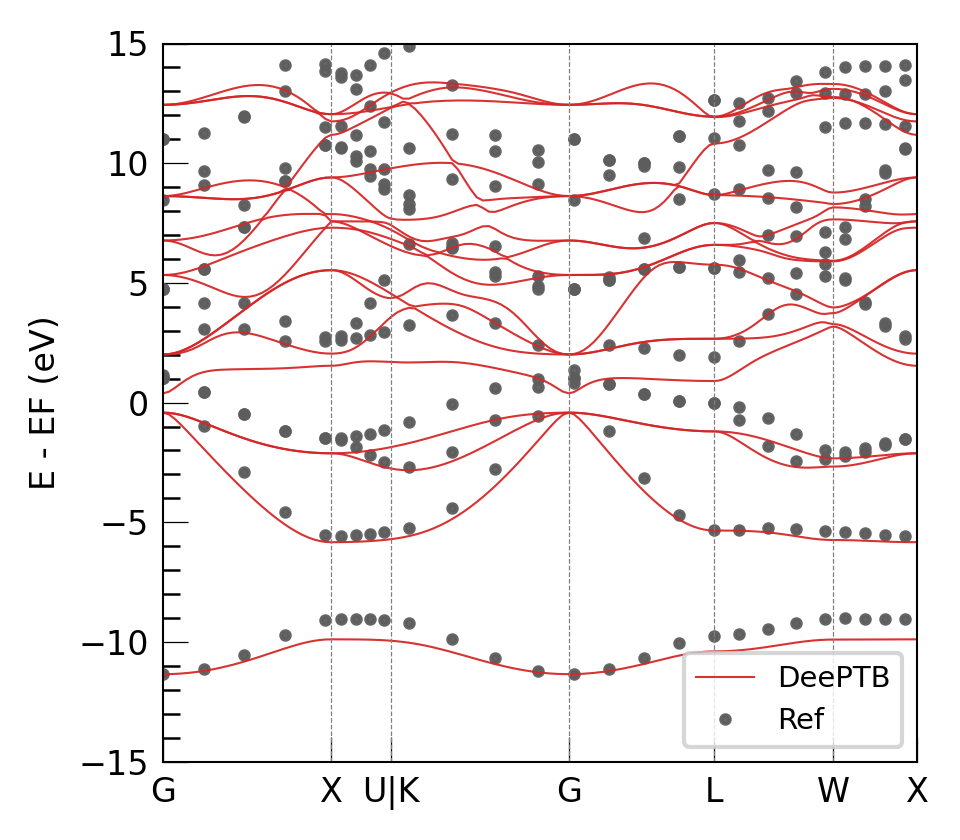

In [112]:
!dptb run band.json -i sktb.json -o  band 
# display the band plot:
from IPython.display import Image, display
import os
image_path = f'./band/results/band.png'
display(Image(filename=image_path,width=400))

### 2.1 model training (briefly introduce)

In [158]:
# 94.116 s on NVIDIA V100
!pwd
# !dptb train input.json -i sktb.json -o nnsk 
!dptb train input.json -i ./nnsk/checkpoint/nnsk.best.pth -o nnsk2 

/home/mayuan/code/sctheory/DeePTB/examples/GaAs_io_sk/train
TBPLaS is not installed. Thus the TBPLaS is not available, Please install it first.
╭──────────────────────── Deep Learning Tight-Binding ─────────────────────────╮
│                                                                              │
│     ██████████                     ███████████  ███████████ ███████████      │
│    ░░███░░░░███                   ░░███░░░░░███░█░░░███░░░█░░███░░░░░███     │
│     ░███   ░░███  ██████   ██████  ░███    ░███░   ░███  ░  ░███    ░███     │
│     ░███    ░███ ███░░███ ███░░███ ░██████████     ░███     ░██████████      │
│     ░███    ░███░███████ ░███████  ░███░░░░░░      ░███     ░███░░░░░███     │
│     ░███    ███ ░███░░░  ░███░░░   ░███            ░███     ░███    ░███     │
│     ██████████  ░░██████ ░░██████  █████           █████    ███████████      │
│    ░░░░░░░░░░    ░░░░░░   ░░░░░░  ░░░░░           ░░░░░    ░░░░░░░░░░░       │
│                                             

TBPLaS is not installed. Thus the TBPLaS is not available, Please install it first.
╭──────────────────────── Deep Learning Tight-Binding ─────────────────────────╮
│                                                                              │
│     ██████████                     ███████████  ███████████ ███████████      │
│    ░░███░░░░███                   ░░███░░░░░███░█░░░███░░░█░░███░░░░░███     │
│     ░███   ░░███  ██████   ██████  ░███    ░███░   ░███  ░  ░███    ░███     │
│     ░███    ░███ ███░░███ ███░░███ ░██████████     ░███     ░██████████      │
│     ░███    ░███░███████ ░███████  ░███░░░░░░      ░███     ░███░░░░░███     │
│     ░███    ███ ░███░░░  ░███░░░   ░███            ░███     ░███    ░███     │
│     ██████████  ░░██████ ░░██████  █████           █████    ███████████      │
│    ░░░░░░░░░░    ░░░░░░   ░░░░░░  ░░░░░           ░░░░░    ░░░░░░░░░░░       │
│                                                                              │
│                        

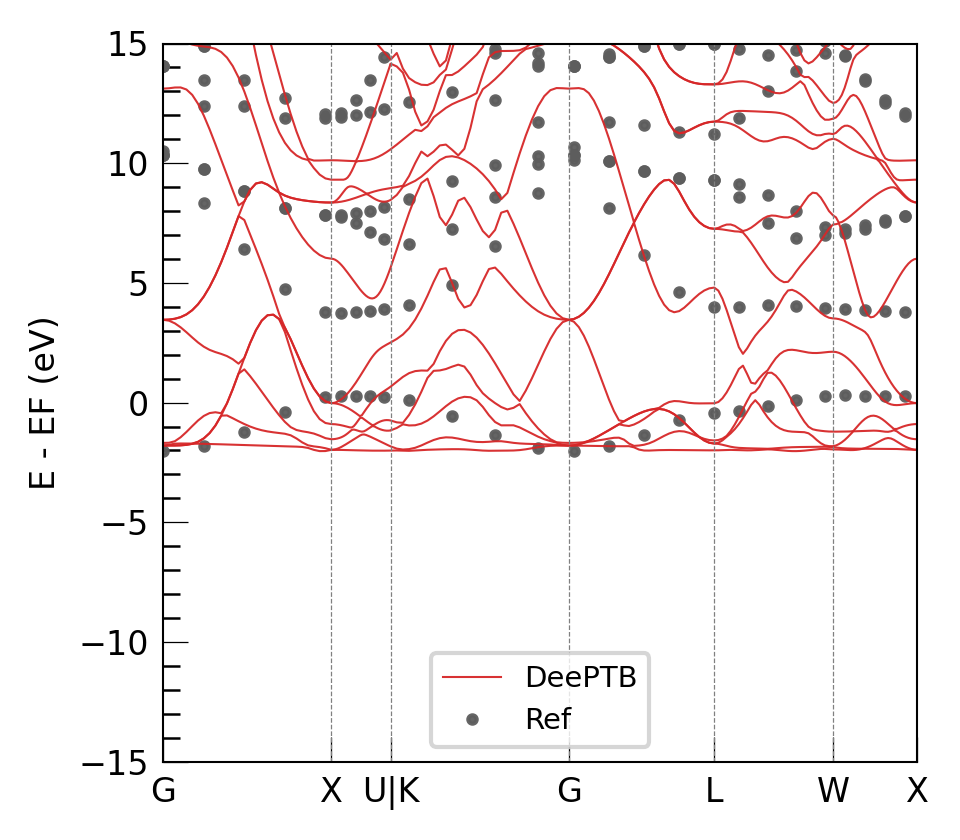

In [155]:
!dptb run band.json -i ./nnsk/checkpoint/nnsk.best.pth -o band_train
# !dptb run band.json -i ./ref_ckpt/nnsk_tr1.pth -o band_train

# display the band plot:
from IPython.display import Image, display
import os
image_path = f'./band_train/results/band.png'
display(Image(filename=image_path,width=400))

We can also continue training from the previous step's training results for one more round.

In [156]:
!dptb train input.json -i ./nnsk/checkpoint/nnsk.best.pth -o nnsk2

TBPLaS is not installed. Thus the TBPLaS is not available, Please install it first.
╭──────────────────────── Deep Learning Tight-Binding ─────────────────────────╮
│                                                                              │
│     ██████████                     ███████████  ███████████ ███████████      │
│    ░░███░░░░███                   ░░███░░░░░███░█░░░███░░░█░░███░░░░░███     │
│     ░███   ░░███  ██████   ██████  ░███    ░███░   ░███  ░  ░███    ░███     │
│     ░███    ░███ ███░░███ ███░░███ ░██████████     ░███     ░██████████      │
│     ░███    ░███░███████ ░███████  ░███░░░░░░      ░███     ░███░░░░░███     │
│     ░███    ███ ░███░░░  ░███░░░   ░███            ░███     ░███    ░███     │
│     ██████████  ░░██████ ░░██████  █████           █████    ███████████      │
│    ░░░░░░░░░░    ░░░░░░   ░░░░░░  ░░░░░           ░░░░░    ░░░░░░░░░░░       │
│                                                                              │
│                        

TBPLaS is not installed. Thus the TBPLaS is not available, Please install it first.
╭──────────────────────── Deep Learning Tight-Binding ─────────────────────────╮
│                                                                              │
│     ██████████                     ███████████  ███████████ ███████████      │
│    ░░███░░░░███                   ░░███░░░░░███░█░░░███░░░█░░███░░░░░███     │
│     ░███   ░░███  ██████   ██████  ░███    ░███░   ░███  ░  ░███    ░███     │
│     ░███    ░███ ███░░███ ███░░███ ░██████████     ░███     ░██████████      │
│     ░███    ░███░███████ ░███████  ░███░░░░░░      ░███     ░███░░░░░███     │
│     ░███    ███ ░███░░░  ░███░░░   ░███            ░███     ░███    ░███     │
│     ██████████  ░░██████ ░░██████  █████           █████    ███████████      │
│    ░░░░░░░░░░    ░░░░░░   ░░░░░░  ░░░░░           ░░░░░    ░░░░░░░░░░░       │
│                                                                              │
│                        

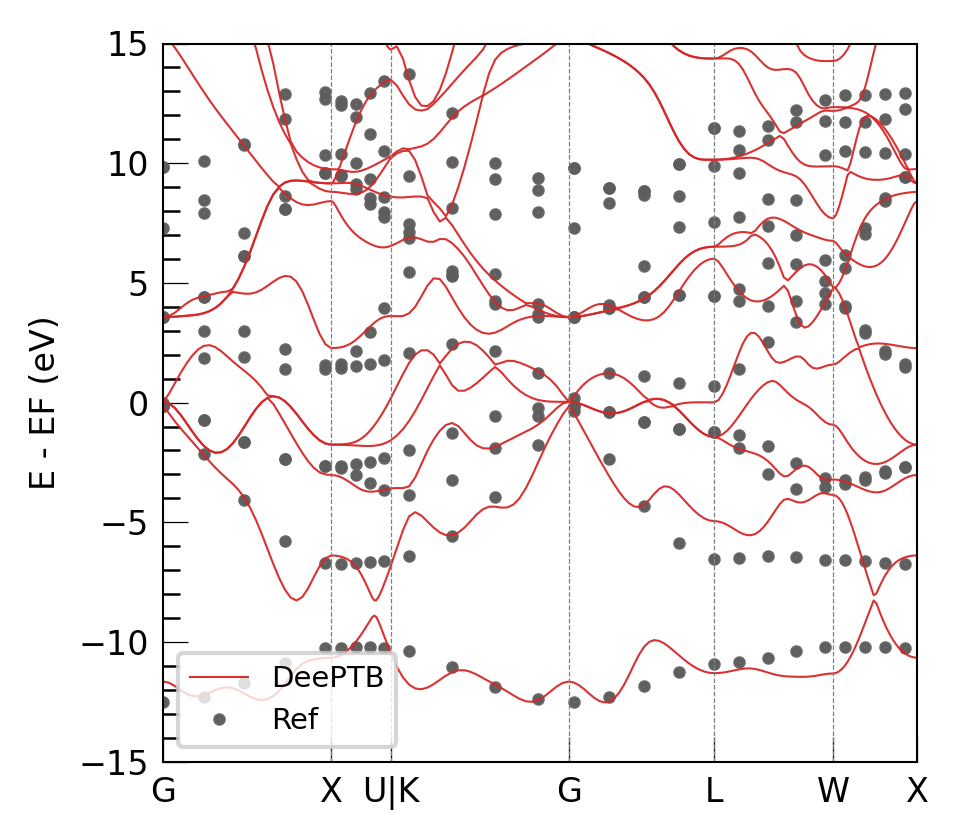

In [157]:
!dptb run band.json -i ./nnsk2/checkpoint/nnsk.best.pth -o band_train
# !dptb run band.json -i ./ref_ckpt/nnsk_tr2.pth -o band_train

# display the band plot:
from IPython.display import Image, display
import os
image_path = f'./band_train/results/band.png'
display(Image(filename=image_path,width=400))

<div style="color:black; background-color:#FFF3E9; border: 1px solid #FFE0C3; border-radius: 10px; margin-bottom:1rem">
    <p style="margin:1rem; padding-left: 1rem; line-height: 2.5;">
        Author: <a style="font-weight:normal" href="mailto:guqq@ustc.edu.cn">Gu, Qiangqiang : guqq@ustc.edu.cn</a>
    </p>
    <p style="margin:1rem; padding-left: 1rem; line-height: 2.5;">
        Thank you for reading!
    </p>
    <p style="margin:1rem; padding-left: 1rem; line-height: 2.5;">
        For more information about training, please refer to tutorial 3.
    </p>


</div>